# Automatic Location Planning for Multiple mmWave Small Cells based on SNR Gradient Ascent with Adam Optimizer in 3D Ray Tracing Engine.

## Import libraries

In [1]:
import os, sys
sys.path.append('..')
from main import Env

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
import numpy as np
np.random.seed(446655)

In [4]:
SCENE_PATH = os.path.join(os.getcwd(), "../obj/poznan.obj")

In [5]:
SCENE_IMG = os.path.join(os.getcwd(), "../obj/poz.png")

## Connect to the ray tracing engine
Connect to a ray tracing server

![](../obj/rt.gif)

In [6]:
env = Env('127.0.0.1', 8877) # connect to local ray tracer
env.reset() # reset

Server: Hello Client 


### Small Cell Variables

Set up for each small cell has transmitt power for 24 dBm with 28 GHz carrier frequency.

In [7]:
transmit_power = 24 # == 24 dBm
transmit_frequency = 28e9 # == 28 GHz
epsilon = 0.001 # small number for gradient calculation

![](../obj/mmWave.png)
the example how the ray tracing engine produce from 30 GHz mmWave.

### Scene Border

min and max border of the map

In [8]:
min_x = -143.236
max_x = 153.955
min_z = -140.049
max_z = 135.963

## Rules

### User SNR Evaluation
A user device will automatically connect to a station that provides the strongest power.

A user device, i, evaluates the quality by SNR( received power from connected cell over total receive from disconnected cells)
\begin{equation}
    SNR_{i}(x, y, z) = \frac{P_{rx, cell_{connected}}}{\sum{}P_{rx, cell_{disconnected}}}
\end{equation}



### Cell Evaluation
A cell evaluates how well its location is by averaging the SNR of the connected device to the cell.
\begin{equation}
    SNR_{avg} = \frac{1}{N} \sum_{i\rightarrow connected}^M SNR_i
\end{equation}


### The Gradient of Base Station Location
The gradient of the current location can be measured by observing the change of average path loss in small different positions.

\begin{equation}
\partial x = \frac{\partial SNR_{avg}}{\partial x_{cell}} = \frac{SNR_{avg}(x_{cell} + \epsilon , y_{cell}, z_{cell}) - SNR_{avg}(x_{cell} - \epsilon , y_{cell}, z_{cell})}{2\epsilon}
\end{equation}

\begin{equation}
\partial z = \frac{\partial SNR_{avg}}{\partial z_{cell}}  = \frac{SNR_{avg}(x_{cell}  , y_{cell}, z_{cell} + \epsilon) - SNR_{avg}(x_{cell} , y_{cell}, z_{cell} - \epsilon)}{2\epsilon}
\end{equation}

### Update the location
Then, the location can be updated by its current slope to the higher value as gradient ascent to the better location with lower loss.

\begin{equation}
x_{cell} := x_{cell} + \alpha * adam\_d x_{cell} 
\end{equation}
\begin{equation}
z_{cell} := z_{cell} + \alpha * adam\_d z_{cell} 
\end{equation}

## Adam Optimizer

 an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization.

In [9]:
class Adam:
    def __init__(self, beta_1, beta_2):
        self.b1 = beta_1
        self.b2 = beta_2
        self.v_dx, self.s_dx = 0,0 
        self.t = 1
    def grad(self, dx):
        self.v_dx = self.b1*self.v_dx + (1-self.b1)*dx # momentum
        self.s_dx = self.b2*self.s_dx**2 + (1-self.b2)*dx # RMS
        v_correct = self.v_dx/(1-np.power(self.b1,self.t))
        s_correct = self.s_dx/(1-np.power(self.b2,self.t))
        self.t += 1
        return v_correct/(np.sqrt(s_correct)+0.00001)

### Memory of User and Cells

In [10]:
Users = []
Cells = []

In [11]:
class User:
    def __init__(self):
        self.id = 0;
        self.status = {'cell_id':None, 'received_power': None, 'SNR':None}
        self.position = []
        self.generateUser()
        
    def calculate(self):
        max_rec_power_mW = 0
        max_cell_id = 0
        all_rec_power_wW = 0;

        # Calculate all possibile receive signal from cells
        for cell in Cells:
            env.com.connect_user_to_station(cell.id, self.id)
            info = env.com.ask_user_info(self.id)
            if info['result']['total_attenuation'] is None:
                continue
            env.com.disconnect_user_from_station(cell.id, self.id)
            rec_power_dBm = transmit_power + info['result']['total_attenuation'] # attenuation is minus
            rec_power_mW = np.power(10,rec_power_dBm/10)
            all_rec_power_wW += rec_power_mW
            if rec_power_mW > max_rec_power_mW:
                max_rec_power_mW = rec_power_mW
                max_cell_id = info['station']
                
        if max_rec_power_mW == 0:
            return # cannot find a station
        # Conclude the signal result
        self.status['cell_id'] = max_cell_id
        self.status['received_power'] =  10*np.log10(max_rec_power_mW)
        self.status['SNR'] = 10*np.log10( max_rec_power_mW/(all_rec_power_wW-max_rec_power_mW))
    
    def generateUser(self):
        position = [0, -10, 0]
        while env.com.is_outdoor(position) is False:
            x = np.random.uniform(min_x*2/3,max_x*2/3)
            z = np.random.uniform(min_z*2/3,max_z*2/3)
            y = np.random.uniform(1.5, 1.8)
            position = [x, y, z]
        env.com.add_user(position)
        self.id = env.com.ask_users_info()[-1]
        self.position = position


In [12]:
class Cell:
    def __init__(self):
        self.id = 0
        self.position = []
        self.generateCell()
        self.xOptimizer = Adam(0.9, 0.99)
        self.zOptimizer = Adam(0.9, 0.99)
        
    def move(self, position):
        self.position = position;
        env.com.move_station_to(self.id, position, [0.0, 0.0, 0.0])
        for user in Users:
            user.calculate()
        
    def generateCell(self):
        position = [0, -10, 0]
        while env.com.is_outdoor(position) is False:
            x = np.random.uniform(min_x/2,max_x/2)
            z = np.random.uniform(min_z/2,max_z/2)
            y = np.random.uniform(4, 8)
            position = [x, y, z]
        env.com.add_station(position, [0.0, 0.0, 0.0], transmit_frequency)
        self.id = env.com.ask_stations_info()[-1]
        self.position = position

    def countAvgConnectedSNR(self):
        avg_SNR = 0
        cnt_user = 0
        for user in Users:
            if user.status['cell_id'] == self.id:
                avg_SNR += user.status['SNR']
                cnt_user += 1
        if cnt_user == 0:
            return None
        return avg_SNR/cnt_user

    def getXZGradients(self):
        current_pos = self.position
        x_plus = [current_pos[0]+epsilon, current_pos[1], current_pos[2]]
        x_minus = [current_pos[0]-epsilon, current_pos[1], current_pos[2]]
        self.move(x_plus)
        SNR_x_plus = self.countAvgConnectedSNR()
        if SNR_x_plus is None:
            self.move(current_pos)
            return None, None
        self.move(x_minus)
        SNR_x_minus = self.countAvgConnectedSNR()
        if SNR_x_minus is None:
            self.move(current_pos)
            return None, None
        z_plus = [current_pos[0], current_pos[1], current_pos[2]+epsilon]
        z_minus = [current_pos[0], current_pos[1], current_pos[2]-epsilon]
        self.move(z_plus)
        SNR_z_plus = self.countAvgConnectedSNR()
        if SNR_z_plus is None:
            self.move(current_pos)
            return None, None
        self.move(z_minus)
        SNR_z_minus = self.countAvgConnectedSNR()
        if SNR_z_minus is None:
            self.move(current_pos)
            return None, None
        dx = (SNR_x_plus - SNR_x_minus)/(2*epsilon)
        dz = (SNR_z_plus - SNR_z_minus)/(2*epsilon)
        return dx, dz

In [13]:
def Display3D():
    ue_x_list,ue_y_list, ue_z_list = [],[],[]
    cell_x_list,cell_y_list, cell_z_list = [],[],[]
    
    for user in Users:
        position = user.position
        ue_x_list.append(position[0])
        ue_y_list.append(position[1])
        ue_z_list.append(position[2])
    
    for cell in Cells:
        position = cell.position
        cell_x_list.append(position[0])
        cell_y_list.append(position[1])
        cell_z_list.append(position[2])
        
    env.open(SCENE_PATH)
    env.visualise(ues = [ue_x_list,ue_y_list, ue_z_list], bss = [cell_x_list,cell_y_list,cell_z_list])

In [14]:
def Display2D():
    user_x_list, user_z_list = [],[]
    cell_x_list, cell_z_list = [],[]
    for user in Users:
        position = user.position
        user_x_list.append(position[0])
        user_z_list.append(position[2]*-1) # flip axis
    
    for cell in Cells:
        position = cell.position
        cell_x_list.append(position[0])
        cell_z_list.append(position[2]*-1) # flip axis
    
    #fig, ax = plt.subplots()
    img = plt.imread(SCENE_IMG)
    plt.imshow(img, extent=[min_x, max_x, min_z, max_z])
    plt.scatter(user_x_list, user_z_list, c="blue")
    plt.scatter(cell_x_list, cell_z_list, c="red")
    plt.xlim(min_x, max_x)
    plt.ylim(min_z, max_z)
    plt.axis('off')

## Simulation

### Randomly generate users

In [15]:
for i in range(25):
    Users.append(User())

### Randomly generate cells

In [16]:
for i in range(6):
    Cells.append(Cell())

### Calculate User Connections

In [17]:
for user in Users:
    user.calculate()

### Check users and cells on map

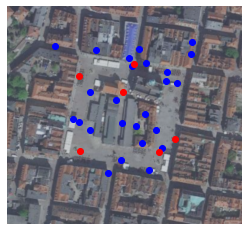

In [18]:
Display2D()

## Run Gradient Ascent

### Hyperparameters

In [19]:
learning_rate = 0.01

In [ ]:
total_SNR = []
for t in range(10):
    Display2D()
    plt.savefig('../obj/{0}.jpeg'.format(t))
    for cell in Cells:
        dx, dz = cell.getXZGradients()
        if dx is None or dz is None:
            continue # hit the wall, do nothing
        new_x = cell.position[0] + cell.xOptimizer.grad(dx)*learning_rate # gradient ascent
        new_z = cell.position[2] + cell.zOptimizer.grad(dz)*learning_rate # gradient ascent
        new_position = [new_x, cell.position[1], new_z]
        print("#"+str(cell.id)+ ":" + str(new_position))
        cell.position = new_position
    # Update position
    for cell in Cells:
        cell.move(cell.position)
    # SNRs
    SNR_t = []
    for user in Users:
        SNR_t.append(user.status['SNR'])
    total_SNR.append(SNR_T)

#363:[-51.88327888864224, 6.985720736316706, -48.17024871347888]


In [ ]:
np.savez('../try.npz', x=np.array(total_SNR))

In [ ]:
env.disconnect()

### Trashes

In [ ]:
#Display3D() # Problem with 3D from ipyvolumn is lagging the browser